In [72]:
#Prepare document:
#use PDFMiner
#run from command line: pdf2txt.py -o NewTextFileName.txt -t text PDFName.pdf
#creates TXT file from PDF. still lots of whitespace

import re
import pandas as pd




In [192]:
def get_SCOTUS_words(case_num):
    #read lines from TXT file as list of strings
    #if type(case_num) != 'string':
    #    raise ValueError('case_num must be a string')
    url = 'C:/Users/bschroeder/Documents/DataScience/' + str(case_num) + '.txt'
    lines = [line.rstrip('\n') for line in open(url)]
    #RegEx for empty string, whitespace, header, footer, jibberish text, or line/page number
    cleanup = re.compile('(^$|^\s{1,10}|^Alderson|^OfficialÂ|^Official - Subject|^Â|^\x0c|^[0-9]{1,2} ?)')
    #remove cleanup text
    lines[:] = [x for x in lines if not cleanup.match(x)]
    #correct for hyphens
    lines[:] = [x.replace('Â\xad','-') for x in lines]
    #replace double-spaces with single
    lines[:] = [x.replace('  ',' ') for x in lines]
    #RegEx for all speakers (Mr, Ms, Solicitor General, Chief Justice, Justice)
    reSpeaking = re.compile('^(M.\.|GENERAL|CHIEF JUSTICE|JUSTICE).*:')
    #RegEx for all non-Justice (Mr, Ms, Solicitor General)
    reOrator = re.compile('^(M.\.|GENERAL) {1,2}.*:')
    #instantiate blanks
    Speakers = pd.DataFrame(index=[],columns = ['Side', 'Attorney', 'Speaker', 'Words'])
    newwords = ''
    speaker = ''
    attorney = ''
    side = ''
    x = 0
    #if line begins with speaker, append the previous statement with the previous Speaker
    #otherwise continue to add to the statement
    for i in lines:
        if reSpeaking.match(i):
            if x > 0:
                NewLine = pd.DataFrame(data=[[side,attorney,speaker,newwords]],index=[x],
                                       columns=['Side', 'Attorney','Speaker', 'Words'])
                Speakers = Speakers.append(NewLine)
            x += 1
            speaker = i.split(': ')[0]
            newwords = i.split(': ')[1]
            if reOrator.match(i):
                if speaker != attorney:
                    attorney = speaker
        else:
            newwords += i
        #if a new orator is encountered, change the Side
        if (i.split('THE')[0] == 'ON BEHALF OF ')|(i.split('THE')[0] == 'SUPPORTING '): 
            #split twice because of trailing space and because some transcripts include "RESPONDENT FOR CASE_NUM"
            side = i.split('THE ')[1].split(' ')[0] 
            if side=='RESPONDENTS':
                side='RESPONDENT'
            if side=='PETITIONERS':
                side='PETITIONER'
            attorney = ''
    #add Length of each statement
    length = []
    for i in Speakers.index:
        length.append(len(Speakers.iloc[i-1].Words))
    Speakers['Length'] = length
    return Speakers;

In [193]:
def get_SCOTUS_details(case_num):
    #get words list via function
    CaseSpeakers = get_SCOTUS_words(case_num)
    #get stats per speaker for petitioner side
    pRoberts = CaseSpeakers[(CaseSpeakers['Side'] == 'PETITIONER') & 
                        (CaseSpeakers['Speaker'] == 'CHIEF JUSTICE ROBERTS')].Length.sum()
    pKennedy = CaseSpeakers[(CaseSpeakers['Side'] == 'PETITIONER') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE KENNEDY')].Length.sum()
    pThomas = CaseSpeakers[(CaseSpeakers['Side'] == 'PETITIONER') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE THOMAS')].Length.sum()
    pGinsburg = CaseSpeakers[(CaseSpeakers['Side'] == 'PETITIONER') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE GINSBURG')].Length.sum()
    pBreyer = CaseSpeakers[(CaseSpeakers['Side'] == 'PETITIONER') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE BREYER')].Length.sum()
    pAlito = CaseSpeakers[(CaseSpeakers['Side'] == 'PETITIONER') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE ALITO')].Length.sum()
    pSotomayor = CaseSpeakers[(CaseSpeakers['Side'] == 'PETITIONER') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE SOTOMAYOR')].Length.sum()
    pKagan = CaseSpeakers[(CaseSpeakers['Side'] == 'PETITIONER') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE KAGAN')].Length.sum()
    pGorsuch = CaseSpeakers[(CaseSpeakers['Side'] == 'PETITIONER') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE GORSUCH')].Length.sum()
    petitioner = CaseSpeakers[(CaseSpeakers['Side'] == 'PETITIONER') & 
                        (CaseSpeakers['Speaker'] != 'CHIEF JUSTICE ROBERTS') &
                         (CaseSpeakers['Speaker'] != 'JUSTICE KENNEDY') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE THOMAS') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE GINSBURG') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE BREYER') &
                         (CaseSpeakers['Speaker'] != 'JUSTICE ALITO') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE SOTOMAYOR') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE KAGAN') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE GORSUCH')].Length.sum()
    #get stats per speaker for respondent side
    rRoberts = CaseSpeakers[(CaseSpeakers['Side'] == 'RESPONDENT') & 
                        (CaseSpeakers['Speaker'] == 'CHIEF JUSTICE ROBERTS')].Length.sum()
    rKennedy = CaseSpeakers[(CaseSpeakers['Side'] == 'RESPONDENT') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE KENNEDY')].Length.sum()
    rThomas = CaseSpeakers[(CaseSpeakers['Side'] == 'RESPONDENT') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE THOMAS')].Length.sum()
    rGinsburg = CaseSpeakers[(CaseSpeakers['Side'] == 'RESPONDENT') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE GINSBURG')].Length.sum()
    rBreyer = CaseSpeakers[(CaseSpeakers['Side'] == 'RESPONDENT') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE BREYER')].Length.sum()
    rAlito = CaseSpeakers[(CaseSpeakers['Side'] == 'RESPONDENT') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE ALITO')].Length.sum()
    rSotomayor = CaseSpeakers[(CaseSpeakers['Side'] == 'RESPONDENT') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE SOTOMAYOR')].Length.sum()
    rKagan = CaseSpeakers[(CaseSpeakers['Side'] == 'RESPONDENT') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE KAGAN')].Length.sum()
    rGorsuch = CaseSpeakers[(CaseSpeakers['Side'] == 'RESPONDENT') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE GORSUCH')].Length.sum()
    respondent = CaseSpeakers[(CaseSpeakers['Side'] == 'RESPONDENT') & 
                        (CaseSpeakers['Speaker'] != 'CHIEF JUSTICE ROBERTS') &
                         (CaseSpeakers['Speaker'] != 'JUSTICE KENNEDY') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE THOMAS') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE GINSBURG') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE BREYER') &
                         (CaseSpeakers['Speaker'] != 'JUSTICE ALITO') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE SOTOMAYOR') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE KAGAN') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE GORSUCH')].Length.sum()
    #combine into list and transform to dataframe
    casedetails = [[case, pRoberts, pKennedy, pThomas, pGinsburg, pBreyer,
                                 pAlito, pSotomayor, pKagan, pGorsuch, petitioner,
                                 rRoberts, rKennedy, rThomas, rGinsburg, rBreyer,
                                 rAlito, rSotomayor, rKagan, rGorsuch, respondent]]
    CaseSummary = pd.DataFrame(data=casedetails, columns=['Case',
                                'P Roberts', 'P Kennedy', 'P Thomas', 'P Ginsburg', 'P Breyer', 
                                'P Alito', 'P Sotomayor', 'P Kagan', 'P Gorsuch', 'Petitioner',
                                'R Roberts', 'R Kennedy', 'R Thomas', 'R Ginsburg', 'R Breyer', 
                                'R Alito', 'R Sotomayor', 'R Kagan', 'R Gorsuch', 'Respondent'])
    return CaseSummary;

In [206]:
Summary = pd.DataFrame(columns=['Case',
                                'P Roberts', 'P Kennedy', 'P Thomas', 'P Ginsburg', 'P Breyer', 
                                'P Alito', 'P Sotomayor', 'P Kagan', 'P Gorsuch', 'Petitioner',
                                'R Roberts', 'R Kennedy', 'R Thomas', 'R Ginsburg', 'R Breyer', 
                                'R Alito', 'R Sotomayor', 'R Kagan', 'R Gorsuch', 'Respondent'])

In [198]:
#ignoring case '15-1039' because it refers to both sides as petitioner
cases = ['16-399','16-605','16-373','16-529','16-349','15-577','16-240','16-5294','16-6219','16-466','16-405','16-309']


In [207]:
for case in cases:
    Summary = Summary.append(get_SCOTUS_details(case))

In [208]:
Summary.reset_index(inplace=True,drop=True)

In [209]:
Summary

,Case,P Roberts,P Kennedy,P Thomas,P Ginsburg,P Breyer,P Alito,P Sotomayor,P Kagan,P Gorsuch,...,R Roberts,R Kennedy,R Thomas,R Ginsburg,R Breyer,R Alito,R Sotomayor,R Kagan,R Gorsuch,Respondent
0,16-399,1049,408,0,1089,0,893,1590,521,2573,...,3562,0,0,377,2251,852,1207,4860,1802,20502
1,16-605,1472,1025,0,1375,1716,789,1417,1469,812,...,3755,1144,0,250,2705,846,1243,0,2425,17627
2,16-373,606,905,0,39,2232,902,923,308,827,...,1268,91,0,1634,1154,0,1791,3180,0,21720
3,16-529,671,810,0,1386,0,994,2494,349,342,...,3709,1025,0,694,3072,321,1115,1744,858,21370
4,16-349,1415,0,0,795,3057,2394,0,905,0,...,396,0,0,1257,675,0,846,594,0,25512
5,15-577,919,1468,0,1403,1166,1037,3019,3899,0,...,1924,325,0,0,3849,3154,884,2666,1130,14621
6,16-240,2705,0,0,850,851,2722,2238,661,2289,...,1440,758,0,279,3511,1042,872,3301,0,17537
7,16-5294,2513,2025,0,893,1047,2697,2259,1125,1136,...,115,973,0,1867,3443,821,277,4791,423,14754
8,16-6219,3575,1061,0,754,3014,2876,1657,0,2850,...,408,727,0,628,3657,304,2088,5636,0,13542
9,16-466,483,1365,0,1594,1357,95,3600,2891,445,...,2339,552,0,1484,2645,100,198,2815,1386,20326


In [210]:
file='SCOTUS.csv'

In [211]:
Summary.to_csv(file)

## Plotting

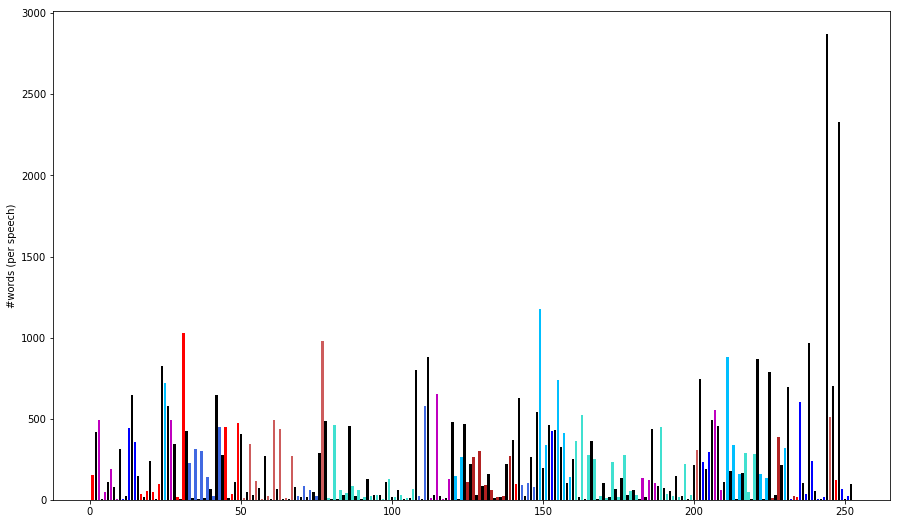

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

speakers = get_SCOTUS_words(cases[7])

#color-code Justices
speakers['color'] = speakers['Speaker'].map({'CHIEF JUSTICE ROBERTS': 'r',
                                             'JUSTICE KENNEDY': 'm','JUSTICE ALITO': 'indianred','JUSTICE GORSUCH': 'firebrick',
                                            'JUSTICE GINSBURG': 'b','JUSTICE BREYER': 'turquoise','JUSTICE SOTOMAYOR': 'royalblue',
                                            'JUSTICE KAGAN': 'deepskyblue'})
#fill remaining (attorneys) as black
speakers['color'].fillna('k', inplace=True)

plt.figure(num=1, figsize=(15, 9));
ax = plt.bar(x=speakers.index,height=speakers.Length,color=speakers.color);
plt.ylabel('#words (per speech)');